# Lesson 5: Coding and Financial Analysis

## Setup

In [1]:
import os
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("AZURE_OPENAI_API_KEY")
_set_env("AZURE_OPENAI_ENDPOINT")
_set_env("AZURE_OPENAI_API_VERSION")
_set_env("AZURE_OPENAI_DEPLOYMENT_NAME")

In [2]:
llm_config: dict = {
    "config_list": [
        {
            "model": os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
            "api_type": "azure",
            "api_key": os.environ["AZURE_OPENAI_API_KEY"],
            "base_url": os.environ["AZURE_OPENAI_ENDPOINT"],
            "api_version": os.environ["AZURE_OPENAI_API_VERSION"],
        }
    ]
}

## Define a code executor

In [3]:
from autogen.coding import LocalCommandLineCodeExecutor

executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="coding",
)

## Create agents 

In [4]:
from autogen import ConversableAgent, AssistantAgent

### 1. Agent with code executor configuration

In [5]:
code_executor_agent: ConversableAgent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="ALWAYS",
    default_auto_reply="Please continue. If everything is done, reply 'TERMINATE'.",
)

### 2. Agent with code writing capability

In [6]:
code_writer_agent = AssistantAgent(
    name="code_writer_agent",
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)

In [7]:
code_writer_agent_system_message = code_writer_agent.system_message

In [8]:
print(code_writer_agent_system_message)

You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feed

## The task!

Ask the two agents to collaborate on a stock analysis task.

In [9]:
import datetime

today = datetime.datetime.now().date()
message = (
    f"Today is {today}. "
    "Create a plot showing stock gain YTD for NVDA and TLSA. "
    "Make sure the code is in markdown code block and save the figure"
    " to a file ytd_stock_gains.png."
    ""
)

<p style="background-color:#ECECEC; padding:15px; "> <b>Note:</b> In this lesson, you will use GPT 4 for better results. Please note that the lesson has a quota limit. If you want to explore the code in this lesson further, we recommend trying it locally with your own API key.

**Note**: You might see a different set of outputs than those shown in the video. The agents collaborate to generate the code needed for your task, and they might produce code with errors in the process. However, they will ultimately provide a correct code in the end.

In [10]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=message,
)

code_executor_agent (to code_writer_agent):

Today is 2025-03-20. Create a plot showing stock gain YTD for NVDA and TLSA. Make sure the code is in markdown code block and save the figure to a file ytd_stock_gains.png.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

To create a plot showing stock gain Year-To-Date (YTD) for NVDA (NVIDIA Corporation) and TLSA (Telos Corporation), we first need to gather the current stock prices for both companies as of today (March 20, 2025) and their respective prices at the beginning of the year. We will then calculate the YTD gains, plot the results, and save the figure to a file named `ytd_stock_gains.png`.

Here is the plan:

1. Use the `yfinance` library to download historical stock price data for NVDA and TLSA.
2. Calculate the YTD gains based on the stock price at the beginning of the year and the current price.
3. Plot the YTD gains using the `matplotlib` library.
4. 

## Let's see the plot!

**Note**: 
* Your plot might differ from the one shown in the video because the LLM's freestyle code generation could choose a different plot type, such as a bar plot. 
* You can re-run the previous cell and check the generated code. If it produces a bar plot, remember you can directly specify your preference by asking for a specific plot type instead of a bar plot.

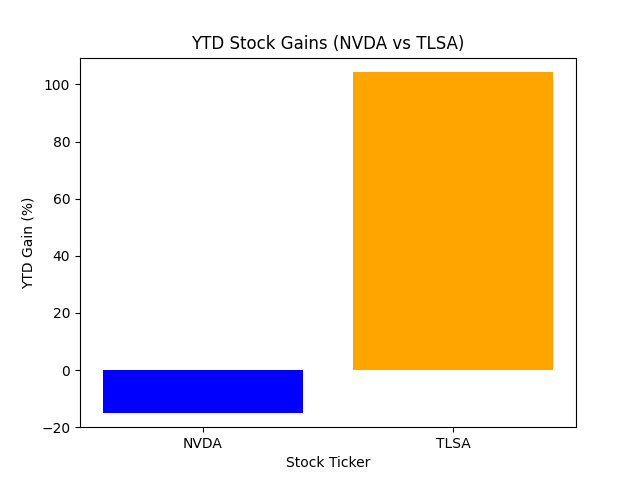

In [11]:
import os
from IPython.display import Image

Image(os.path.join("coding", "ytd_stock_gains.png"))

**Note**: The agent will automatically save the code in a .py file and the plot in a .png file. To access and check the files generated by the agents, go to the `File` menu and select `Open....` Then, open the folder named `coding` to find all the generated files.

## User-Defined Functions

Instead of asking LLM to generate the code for downloading stock data 
and plotting charts each time, you can define functions for these two tasks and have LLM call these functions in the code.

In [12]:
def get_stock_prices(stock_symbols, start_date, end_date):
    """Get the stock prices for the given stock symbols between
    the start and end dates.

    Args:
        stock_symbols (str or list): The stock symbols to get the
        prices for.
        start_date (str): The start date in the format
        'YYYY-MM-DD'.
        end_date (str): The end date in the format 'YYYY-MM-DD'.

    Returns:
        pandas.DataFrame: The stock prices for the given stock
        symbols indexed by date, with one column per stock
        symbol.
    """
    import yfinance

    stock_data = yfinance.download(stock_symbols, start=start_date, end=end_date)
    return stock_data.get("Close")

In [13]:
def plot_stock_prices(stock_prices, filename):
    """Plot the stock prices for the given stock symbols.

    Args:
        stock_prices (pandas.DataFrame): The stock prices for the
        given stock symbols.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    for column in stock_prices.columns:
        plt.plot(stock_prices.index, stock_prices[column], label=column)
    plt.title("Stock Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.savefig(filename)

### Create a new executor with the user-defined functions

In [14]:
executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="coding",
    functions=[get_stock_prices, plot_stock_prices],
)

In [15]:
code_writer_agent_system_message += executor.format_functions_for_prompt()
print(code_writer_agent_system_message)

You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feed

In [16]:
code_writer_agent = ConversableAgent(
    name="code_writer_agent",
    system_message=code_writer_agent_system_message,
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)

In [17]:
code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="ALWAYS",
    default_auto_reply="Please continue. If everything is done, reply 'TERMINATE'.",
)

### Start the same task again!

In [20]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=f"Today is {today}."
    "Download the stock prices YTD for NVDA and TSLA and create"
    "a plot. Make sure the code is in markdown code block and "
    "save the figure to a file stock_prices_YTD_plot.png.",
)

code_executor_agent (to code_writer_agent):

Today is 2025-03-20.Download the stock prices YTD for NVDA and TSLA and createa plot. Make sure the code is in markdown code block and save the figure to a file stock_prices_YTD_plot.png.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

First, we'll gather the stock prices for NVDA and TSLA from the beginning of the year (2025-01-01) up to today's date (2025-03-20). Then we will plot these prices and save the figure as `stock_prices_YTD_plot.png`.

Here is the complete code to accomplish this task:

```python
# filename: stock_prices_ytd_plot.py
from functions import get_stock_prices, plot_stock_prices
import pandas as pd

# Define stock symbols and date range
stock_symbols = ['NVDA', 'TSLA']
start_date = '2025-01-01'
end_date = '2025-03-20'

# Get stock prices
stock_prices = get_stock_prices(stock_symbols, start_date, end_date)

# Plot the stock prices
plot_stock_

### Plot the results

In [ ]:
Image(os.path.join("coding", "stock_prices_YTD_plot.png"))

**Note**: The agent will automatically save the code in a .py file and the plot in a .png file. To access and check the files generated by the agents, go to the `File` menu and select `Open....` Then, open the folder named `coding` to find all the generated files.